## Soil moisture evolution Schwarzwald (2015- 2022)

1. Map of the Harz Region 
2. Selections of Grid cells for the precipitation, radiation, tempertature and LAI data
3. Running the simple water balance model for the years 2015 to 2022 for the Harz region
4. Make a soil moisture evolution diagramm

### Importing packages 

In [2]:
import folium
import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shutil
import pandas as pd
import math
import geopandas as gpd


### Map of the Harz region and selection of grid cells

In [3]:
file_path = "data/Harz_Aussengrenze/Harz_Aussengrenze.shp"

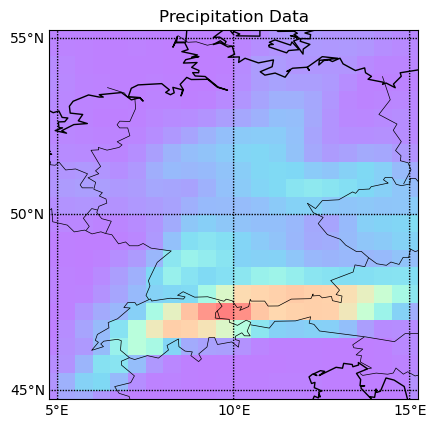

In [4]:
# File paths
precipitation_file = "data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc"

# Open the NetCDF file
nc_file = nc.Dataset(precipitation_file)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  # Using arbitrary time index 50

# Create Basemap instance
m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            projection='cyl', resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot the precipitation data as grid cells
x_mesh, y_mesh = np.meshgrid(lon, lat)
x_mesh, y_mesh = m(x_mesh, y_mesh)
plt.pcolormesh(x_mesh, y_mesh, data, cmap='rainbow', alpha=0.5, label='Precipitation Data')

# Add latitude and longitude lines with labels
m.drawparallels(np.arange(-90., 91., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)

plt.title('Precipitation Data')

# Show the plot
plt.show()

# Close the NetCDF file
nc_file.close()

### Harz

In [5]:
# File path to the Harz shapefile
shapefile_path = "data/harz/harz.gpkg"

# Load the shapefile using geopandas
harz_shape = gpd.read_file(shapefile_path, encoding='latin1')

# Create a Folium map
m = folium.Map()

# Add the shapefile to the map
folium.GeoJson(harz_shape).add_to(m)

# Display the map
m

In [6]:
import geopandas as gpd
from shapely.geometry import box

# File path to the Schwarzwald shapefile
shapefile_path = "data/schwarzwald_naturpark/naturpark_schwarzwald.shp"

# Load the shapefile using geopandas
schwarzwald_shape = gpd.read_file(shapefile_path, encoding='latin1')

# Define the CRS of the shapefile (EPSG:32632)
original_crs = {'init': 'epsg:32632'}

# Convert the bounds to degrees (latitude and longitude)
bounds_deg = schwarzwald_shape.total_bounds
bounds_deg = gpd.GeoSeries([box(bounds_deg[0], bounds_deg[1], bounds_deg[2], bounds_deg[3])], crs=original_crs).to_crs(epsg=4326)[0].bounds

# Print the minimum and maximum longitude and latitude values in degrees
print("Minimum Longitude:", bounds_deg[0])
print("Maximum Longitude:", bounds_deg[2])
print("Minimum Latitude:", bounds_deg[1])
print("Maximum Latitude:", bounds_deg[3])


Minimum Longitude: 7.586294012444659
Maximum Longitude: 8.642403324920886
Minimum Latitude: 47.53134167037793
Maximum Latitude: 48.23995345367079


c:\Users\andre\anaconda3\envs\babadormann\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [7]:
import folium
import geopandas as gpd
from shapely.geometry import box

# File paths
precipitation_file = "data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc"
shapefile_path = "data/schwarzwald_naturpark/naturpark_schwarzwald.shp"

# Open the NetCDF file
nc_file = nc.Dataset(precipitation_file)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  # Using arbitrary time index 50

# Create a Folium map
m = folium.Map()

# Define the CRS of the shapefile (EPSG:32632)
original_crs = {'init': 'epsg:32632'}

# Load the Schwarzwald shapefile using geopandas
schwarzwald_shape = gpd.read_file(shapefile_path, encoding='latin1')

# Convert the bounds to degrees (latitude and longitude)
bounds_deg = schwarzwald_shape.total_bounds
bounds_deg = gpd.GeoSeries([box(bounds_deg[0], bounds_deg[1], bounds_deg[2], bounds_deg[3])], crs=original_crs).to_crs(epsg=4326)[0].bounds

# Add the extent of the Schwarzwald shapefile to the map
folium.Rectangle(bounds=[[bounds_deg[1], bounds_deg[0]], [bounds_deg[3], bounds_deg[2]]],
                 color='blue',
                 fill=True,
                 fill_opacity=0.2,
                 popup='Schwarzwald Extent').add_to(m)

# Close the NetCDF file
nc_file.close()

# Display the map

c:\Users\andre\anaconda3\envs\babadormann\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Reading data

In [9]:
years = np.arange(2015,2023,1)

R_data = []
T_data = []
P_data = []
lai_data = []

file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc' # no need to change

nc_file = nc.Dataset(file_path)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
nc_file.close()

In [32]:
bounds_deg

(7.586294012444659, 47.53134167037793, 8.642403324920886, 48.23995345367079)

In [10]:
lon_grid, lat_grid = np.meshgrid(lon, lat)
min_lon, min_lat, max_lon, max_lat = bounds_deg

In [33]:
# Find indices of lon and lat within the specified bounds
lon_idx = np.where((lon >= min_lon) & (lon <= max_lon))[0]
lat_idx = np.where((lat >= min_lat) & (lat <= max_lat))[0]

# Resulting indices
intersecting_lons = lon[lon_idx]
intersecting_lats = lat[lat_idx]

print("Longitude Indices:", lon_idx)
print("Latitude Indices:", lat_idx)
print("Intersecting Longitudes:", intersecting_lons)
print("Intersecting Latitudes:", intersecting_lats)

Longitude Indices: [6 7]
Latitude Indices: [15]
Intersecting Longitudes: [7.75 8.25]
Intersecting Latitudes: [47.75]


In [ ]:
# File paths
precipitation_file = "data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc"

# Open the NetCDF file
nc_file = nc.Dataset(precipitation_file)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  # Using arbitrary time index 50

# Create Basemap instance
m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            projection='cyl', resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot the precipitation data as grid cells
x_mesh, y_mesh = np.meshgrid(lon, lat)
x_mesh, y_mesh = m(x_mesh, y_mesh)
plt.pcolormesh(x_mesh, y_mesh, data, cmap='rainbow', alpha=0.5, label='Precipitation Data')

# Add latitude and longitude lines with labels
m.drawparallels(np.arange(-90., 91., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)

plt.title('Precipitation Data')

# Show the plot
plt.show()

# Close the NetCDF file
nc_file.close()

In [ ]:
a = np.where(abs(lon-longitude) == min(abs(lon-longitude)))[0][0]
b = np.where(abs(lat-latitude) == min(abs(lat-latitude)))[0][0]

In [ ]:

    # Loop through all files in the folder
counter = 1
for filename in os.listdir(folder_path):
    
    # Init df for current catchment 
    comb_corr_df = pd.DataFrame(columns=['parameters'])
    comb_corr_df['parameters'] = parameter_combinations
    
    data = []
    header_lines_to_skip = 0
    if filename.endswith(".txt"):  # Check if the file is a text file
         file_path = os.path.join(folder_path, filename)
    with open(file_path, "r", encoding='latin1') as file:
        for line in file:
            if line.startswith("# Latitude"):
                latitude = float(line.split(":")[1].strip())
            elif line.startswith("# Longitude"):
                longitude = float(line.split(":")[1].strip())

    a = np.where(abs(lon-longitude) == min(abs(lon-longitude)))[0][0]
    b = np.where(abs(lat-latitude) == min(abs(lat-latitude)))[0][0]
    # now is the time where you could rund a calibration
    with open(file_path, "r", encoding='latin1') as file:
        for line in file:
            # Skip header lines until "DATA" section
            if line.strip() == "# DATA":
                header_lines_to_skip += 1
                break
            else:
                header_lines_to_skip += 1

    # Define column names to read
    columns_to_read = ["YYYY-MM-DD", "Value"]

    # Read data into DataFrame using pandas, skipping the header lines and selecting specific columns
    df = pd.read_csv(file_path, sep=";", skiprows=header_lines_to_skip, skipinitialspace=True, usecols=columns_to_read, encoding='latin1')

    # Convert the 'YYYY-MM-DD' column to datetime format
    df['YYYY-MM-DD'] = pd.to_datetime(df['YYYY-MM-DD'])

    # Filter the DataFrame to include only the data between January 1, 2000, and December 31, 2020
    end_date = pd.to_datetime(str(calibration_time[1] - 1) + '-12-31')
    start_date = pd.to_datetime(str(calibration_time[0]) + '-01-01')
    filtered_df = df[(df['YYYY-MM-DD'] >= start_date) & (df['YYYY-MM-DD'] <= end_date)]
    # get radiation, temperature and precipitation data from netCDF files
    for year in years:   
        file_path1 = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.'+str(year)+'.nc'
        nc_file = nc.Dataset(file_path1)
        # 7,8 is the grid cell of interest for the respective catchment area
        dates = nc_file.variables['time'][:]
        P_data.append(nc_file.variables['tp'][:,b,a])
        nc_file.close()
        file_path1 = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.'+str(year)+'.nc'
        nc_file = nc.Dataset(file_path1)
        #print(nc_file)
        R_data.append(nc_file.variables['nr'][:,b,a])
        nc_file.close()
        file_path1 = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.'+str(year)+'.nc'
        nc_file = nc.Dataset(file_path1)
        T_data.append(nc_file.variables['t2m'][:,b,a])
        nc_file.close()  
        file_path1 = 'data/lai/lai.daily.0d50_CentralEurope.'+str(year)+'.nc'
        nc_file = nc.Dataset(file_path1)
        lai_data.append(nc_file.variables['lai'][:,b,a])
        nc_file.close()  

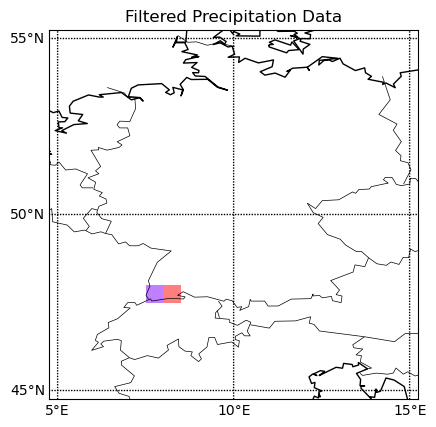

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap

# File paths
precipitation_file = "data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc"

# Open the NetCDF file
nc_file = nc.Dataset(precipitation_file)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  # Using arbitrary time index 50

# Polygon extent boundaries
min_lon, min_lat, max_lon, max_lat = (7.586294012444659, 47.53134167037793, 8.642403324920886, 48.23995345367079)

# Mask data outside the polygon extent
lon_mask = (lon >= min_lon) & (lon <= max_lon)
lat_mask = (lat >= min_lat) & (lat <= max_lat)
data_masked = np.ma.masked_where(~np.outer(lat_mask, lon_mask), data)

# Create Basemap instance
m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            projection='cyl', resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot the filtered precipitation data as grid cells
x_mesh, y_mesh = np.meshgrid(lon, lat)
x_mesh, y_mesh = m(x_mesh, y_mesh)
plt.pcolormesh(x_mesh, y_mesh, data_masked, cmap='rainbow', alpha=0.5, label='Precipitation Data')

# Add latitude and longitude lines with labels
m.drawparallels(np.arange(-90., 91., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)

plt.title('Filtered Precipitation Data')

# Show the plot
plt.show()

# Close the NetCDF file
nc_file.close()
